In [1]:
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from ipywidgets import interact
import numpy as np


In [2]:
# Global Constants
REWARD_TOKEN_TOTAL_SUPPLY = 100_000_000  # Total supply of Reward tokens

# Mining
MINING_EMISSION_BUDGET_PERCENT = 0.05  # 5% of Reward Token total supply
MINING_EMISSION_BUDGET = REWARD_TOKEN_TOTAL_SUPPLY * MINING_EMISSION_BUDGET_PERCENT # Mining Emission Budget
MINING_CONVERSION_RATE = MINING_EMISSION_BUDGET / (REWARD_TOKEN_TOTAL_SUPPLY - MINING_EMISSION_BUDGET) # Mining Conversion Rate

MAX_LIQUIDITY_LOCK_PERIOD = 365

In [3]:
# MiningProgram Class
class MiningProgram:
    def __init__(self, k):
        self.miners = {}  # Store burner info
        self.k = k

    def add_liquidity(self, miner, af_amount_deposited, lock_period_days):
        if self.aggregate_liquidity() > REWARD_TOKEN_TOTAL_SUPPLY:
            return
        
        if self.aggregate_emission() > MINING_EMISSION_BUDGET:
            return
    
        current_time = datetime.now()
        self.miners[miner] = {
            'af_amount_deposited': af_amount_deposited,
            'lock_period': lock_period_days,
            'lock_started_at': current_time,
            'emission': EmissionRegulator.calculate_liquidity_emission(af_amount_deposited, lock_period_days, self.k)
        }

    def aggregate_liquidity(self):
        total_deposited = sum(miner_info['af_amount_deposited'] for miner_info in self.miners.values())
        return total_deposited
    
    def aggregate_emission(self):
        return sum(miner_info['emission'] for miner_info in self.miners.values())

# EmissionRegulator Class
class EmissionRegulator:  

    def calculate_liquidity_emission(deposited_amount, lock_period_days, k):
        discount_factor = 1 / (1 - k * lock_period_days / (MAX_LIQUIDITY_LOCK_PERIOD + 1)) 
        return deposited_amount * MINING_CONVERSION_RATE * discount_factor


In [4]:
# This cell is meant to help define the `k` constant to calculate the discount factor
# Plot the `calculate_liquidity_emission` distribution curve and adjust `k` constant to see how it impacts the curve

deposited_amount = 1

def interactive_mining_emission(k):
    lock_periods = np.linspace(1, 356, 100)  # Range of drain periods from 1 to 356 days
    emissions = [EmissionRegulator.calculate_liquidity_emission(deposited_amount, period, k) for period in lock_periods]
    plt.figure(figsize=(10, 6))
    plt.plot(lock_periods, emissions, label=f'Emissions per deposited token')
    plt.xlabel('Lock Period (days)')
    plt.ylabel('Emission (Reward Tokens)')
    plt.title('Emission per Lock Period')
    plt.legend()
    plt.grid(True)
    plt.show()

interact(interactive_mining_emission, k=(0.01, 1, 0.01))


interactive(children=(FloatSlider(value=0.5, description='k', max=1.0, min=0.01, step=0.01), Output()), _dom_c…

<function __main__.interactive_mining_emission(k)>

In [5]:
# Set K
K = 0.7

In [6]:
# Output Observability functions

# Plotting burning emissions over time
def plot_mining_output(timestamps, mining_emissions):
    plt.figure(figsize=(12, 6))
    plt.plot(timestamps, mining_emissions, linestyle='-', color='r', label='Cumulative Mining Emission Over Time')
    plt.xlabel('Time (days)')
    plt.ylabel('Token Reward Emission')
    plt.title('Token Reward Emission Over Time')
    plt.grid(True)
    plt.legend()
    plt.show()


# Plotting Circulating supply function over time
def plot_total_deposited_output(timestamps, deposited_amounts):
    plt.figure(figsize=(12, 6))
    plt.plot(timestamps, deposited_amounts, linestyle='-', color='g', label='Tokens Deposited Over Time')
    plt.xlabel('Time')
    plt.ylabel('Tokens Deposited')
    plt.title('Tokens Deposited Over Time')
    plt.grid(True)
    plt.legend()
    plt.show()

In [7]:
# Mining Scenarios

# Nominal Scenarios implies, random amounts deposited for random lock periods
def generate_nominal_scenarios(liquidity_mining_program, num_deposit_events, max_deposit_amount, total_days):
    # Initialize the scenario results
    tokens_deposited_over_time = []
    emissions_over_time = []
    timestamps = []
    
    # Define start time
    start_time = datetime.today()

    for i in range(num_deposit_events):
        # Generate random burn data
        miner_name = f"miner_{i + 1}"
        deposit_amount = random.randint(1, max_deposit_amount)  # Random deposit amount
        lock_period = random.randint(0, MAX_LIQUIDITY_LOCK_PERIOD)  # Random lock period


        # Apply the burn event
        liquidity_mining_program.add_liquidity(miner_name, deposit_amount, lock_period)

        # Record the total emission and timestamp after the deposit
        current_time = start_time + timedelta(days=(i * total_days / num_deposit_events))
        timestamps.append(current_time)
        emissions_over_time.append(liquidity_mining_program.aggregate_emission())
        tokens_deposited_over_time.append(liquidity_mining_program.aggregate_liquidity())

    return timestamps, emissions_over_time, tokens_deposited_over_time

# All Max Lock Scenarios implies, random amounts deposited for the maximum lock periods possible
def generate_all_max_lock_scenario(liquidity_mining_program, num_deposit_events, max_deposit_amount, total_days):
    # Initialize the scenario results
    tokens_deposited_over_time = []
    emissions_over_time = []
    timestamps = []
    
    # Define start time
    start_time = datetime.today()

    for i in range(num_deposit_events):
        # Generate random burn data
        miner_name = f"miner_{i + 1}"
        deposit_amount = random.randint(1, max_deposit_amount)  # Random deposit amount
        lock_period = MAX_LIQUIDITY_LOCK_PERIOD


        # Apply the burn event
        liquidity_mining_program.add_liquidity(miner_name, deposit_amount, lock_period)

        # Record the total emission and timestamp after the deposit
        current_time = start_time + timedelta(days=(i * total_days / num_deposit_events))
        timestamps.append(current_time)
        emissions_over_time.append(liquidity_mining_program.aggregate_emission())
        tokens_deposited_over_time.append(liquidity_mining_program.aggregate_liquidity())

    return timestamps, emissions_over_time, tokens_deposited_over_time

# All No Lock Scenarios implies, random amounts deposited without any lock period
def generate_all_no_lock_scenario(liquidity_mining_program, num_deposit_events, max_deposit_amount, total_days):
    # Initialize the scenario results
    tokens_deposited_over_time = []
    emissions_over_time = []
    timestamps = []
    
    # Define start time
    start_time = datetime.today()

    for i in range(num_deposit_events):
        # Generate random burn data
        miner_name = f"miner_{i + 1}"
        deposit_amount = random.randint(1, max_deposit_amount)  # Random deposit amount
        lock_period = 0


        # Apply the burn event
        liquidity_mining_program.add_liquidity(miner_name, deposit_amount, lock_period)

        # Record the total emission and timestamp after the deposit
        current_time = start_time + timedelta(days=(i * total_days / num_deposit_events))
        timestamps.append(current_time)
        emissions_over_time.append(liquidity_mining_program.aggregate_emission())
        tokens_deposited_over_time.append(liquidity_mining_program.aggregate_liquidity())

    return timestamps, emissions_over_time, tokens_deposited_over_time

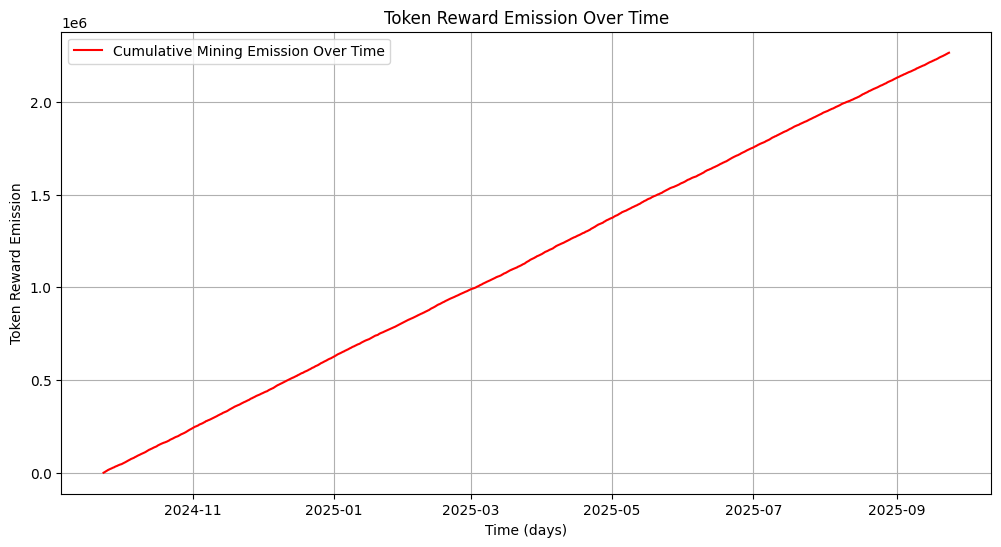

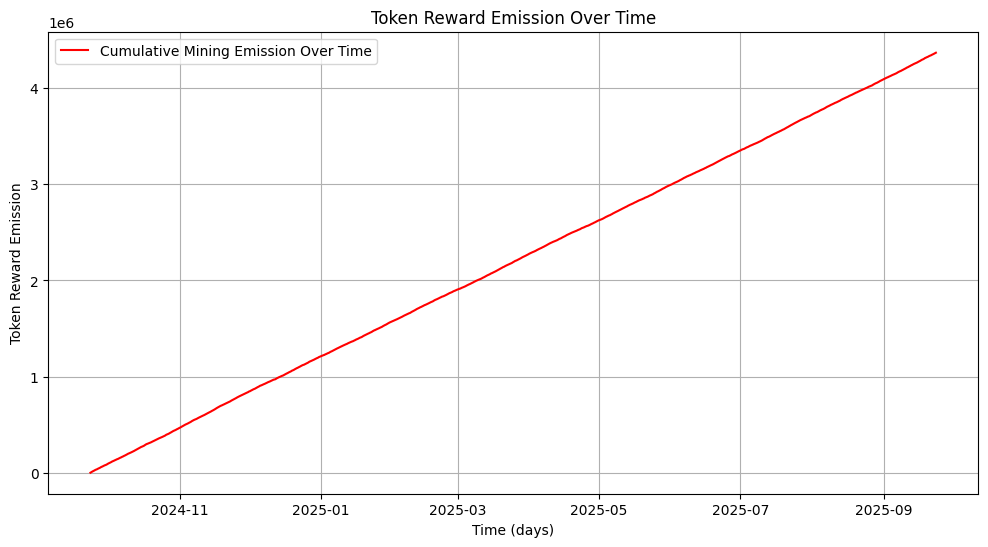

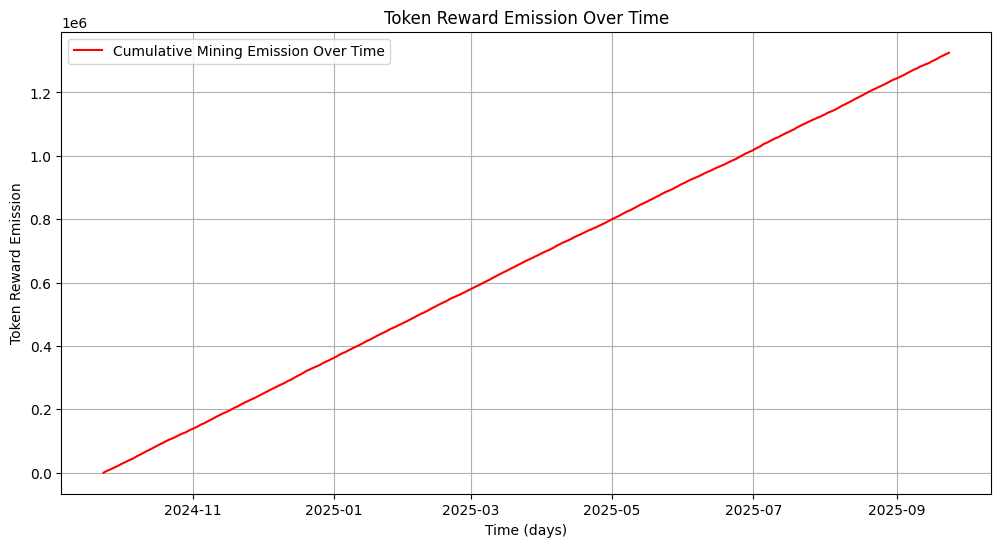

In [8]:
# Scenario Variables :
num_deposit_events=10000
max_deposit_amount=5000

total_days=365


# Initialize Programs
mining_program = MiningProgram(K)
emission_regulator = EmissionRegulator()

# Simulate Scenario
timestamps, mining_emissions, total_deposited = generate_nominal_scenarios(mining_program, num_deposit_events, max_deposit_amount, total_days)

# Plot output
plot_mining_output(timestamps, mining_emissions)

# Initialize Programs
mining_program = MiningProgram(K)
emission_regulator = EmissionRegulator()

# Simulate Scenario
timestamps, mining_emissions, total_deposited = generate_all_max_lock_scenario(mining_program, num_deposit_events, max_deposit_amount, total_days)

# Plot output
plot_mining_output(timestamps, mining_emissions)

# Initialize Programs
mining_program = MiningProgram(K)
emission_regulator = EmissionRegulator()

# Simulate Scenario
timestamps, mining_emissions, total_deposited = generate_all_no_lock_scenario(mining_program, num_deposit_events, max_deposit_amount, total_days)

# Plot output
plot_mining_output(timestamps, mining_emissions)